In [ ]:
#default_exp core
#default_cls_lvl 3

In [ ]:
#export
from fastcore.test import *
from timeseries_fastai.imports import *

In [ ]:
#export
import pandas as pd
from fastcore.all import *
from scipy.io import arff

# Core

> Basic timeseries opening/processing funcs.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
def maybe_unsqueeze(x):
    "Add empty dimension if it is a rank 1 tensor/array"
    if isinstance(x, np.ndarray): return x[None,:] if len(x.shape)==1 else x
    if isinstance(x, Tensor): return x.unsqueeze(0) if len(x.shape)==1 else x
    else: return None

In [ ]:
a = np.random.random(10)
test_eq((1,10), maybe_unsqueeze(a).shape)
test_eq((1,10), maybe_unsqueeze(maybe_unsqueeze(a)).shape) #do nothing

t = torch.rand(10)
test_eq((1,10), maybe_unsqueeze(t).shape)
test_eq((1,10), maybe_unsqueeze(maybe_unsqueeze(t)).shape) #do nothing

A time series is just an array of 1 dimesion.

In [ ]:
#export
def show_array(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    # Handle pytorch axis order
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = maybe_unsqueeze(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-'+c,label=label, **kwargs)
    if title is not None: ax.set_title(title)
    ax.legend()
    return ax

A simple array of 1 channel is `np.arange(10)`.

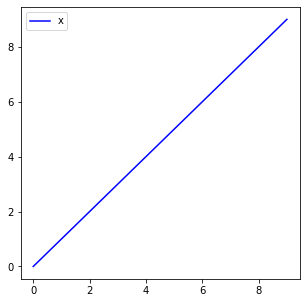

In [ ]:
show_array(np.arange(10));

In [ ]:
# export
class TSeries(TensorBase):
    "Basic Timeseries wrapper"  
    @classmethod
    def create(cls, x): 
        return cls(maybe_unsqueeze(as_tensor(x)))
    
    @property
    def channels(self): return self.shape[0]
    
    @property
    def len(self): return self.shape[-1]
    
    def __repr__(self):
        return f'TSeries(ch={self.channels}, len={self.len})'
    
    def show(self, ctx=None, **kwargs):
        return show_array(self, ctx=ctx, **kwargs)

We can add some noise for the fun

In [ ]:
a = np.arange(10)+np.random.randn(10)

In [ ]:
a.shape

(10,)

As we want to make explicit that is a one channel timeseries, we will `unsqueeze` the first dimension.

In [ ]:
ts2 = TSeries.create(a)

In [ ]:
ts2.data

tensor([[-1.0907,  0.4990,  1.2441,  2.2530,  5.0404,  4.9801,  5.9149,  6.2867,
          8.0063, 10.2405]])

In [ ]:
ts2.shape

torch.Size([1, 10])

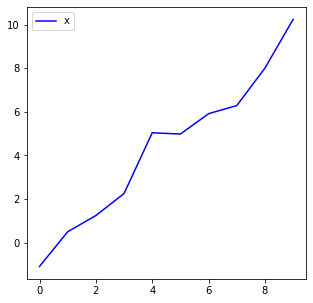

In [ ]:
ts2.show();

## UCR
> The 2018 UCR 128-timeseries dataset

This is the dataset used to benchmark algorithms for Timeseries classification.

In [ ]:
#export
URLs.UCR = 'http://www.timeseriesclassification.com/Downloads/Archives/Univariate2018_arff.zip'

In [ ]:
URLs.UCR

'http://www.timeseriesclassification.com/Downloads/Archives/Univariate2018_arff.zip'

This link has a little problem, that unzips to `Univariate_arff.zip` instead of `Univariate2018_arff.zip`

In [ ]:
#export
def get_ucr():
    "zipped file has different name as .zip"
    ucr_path_2018 = untar_data(URLs.UCR)
    return ucr_path_2018.parent/ucr_path_2018.name.replace('2018', '')

we remove the 2018 at the end of the filename

In [ ]:
ucr_path = get_ucr()

In [ ]:
ucr_path

Path('/home/tc256760/.fastai/data/Univariate_arff')

Each sub task is on a subfolde with task name. For instance we will select 'Adiac' .

In [ ]:
ucr_path.ls()

(#135) [Path('/home/tc256760/.fastai/data/Univariate_arff/PowerCons'),Path('/home/tc256760/.fastai/data/Univariate_arff/PhalangesOutlinesCorrect'),Path('/home/tc256760/.fastai/data/Univariate_arff/Herring'),Path('/home/tc256760/.fastai/data/Univariate_arff/ElectricDevices'),Path('/home/tc256760/.fastai/data/Univariate_arff/CBF'),Path('/home/tc256760/.fastai/data/Univariate_arff/Plane'),Path('/home/tc256760/.fastai/data/Univariate_arff/DataSummaryExpanded_v03.xlsx'),Path('/home/tc256760/.fastai/data/Univariate_arff/MiddlePhalanxTW'),Path('/home/tc256760/.fastai/data/Univariate_arff/ECG5000'),Path('/home/tc256760/.fastai/data/Univariate_arff/CricketZ')...]

In [ ]:
adiac_path = ucr_path/'Adiac'

In [ ]:
adiac_path.ls()

(#5) [Path('/home/tc256760/.fastai/data/Univariate_arff/Adiac/Adiac.txt'),Path('/home/tc256760/.fastai/data/Univariate_arff/Adiac/Adiac_TEST.arff'),Path('/home/tc256760/.fastai/data/Univariate_arff/Adiac/Adiac_TEST.txt'),Path('/home/tc256760/.fastai/data/Univariate_arff/Adiac/Adiac_TRAIN.txt'),Path('/home/tc256760/.fastai/data/Univariate_arff/Adiac/Adiac_TRAIN.arff')]

We can find `.csv` and `.arff` files on this copy of the dataset. We will read the `.arff` files using a helper function. We will store them on pandas DataFrame's

In [ ]:
#export
# "this functions are based on https://github.com/mb4310/Time-Series"
def load_df_ucr(path, task):
    "Loads arff files from UCR"
    try:
        print(f'Loading files from: {path}/{task}')
        dfs = []
        for file in ['TRAIN', 'TEST']:
            filename = f'{task}/{task}_{file}.arff'
            data = arff.loadarff(str(path/filename))
            dfs.append(pd.DataFrame(data[0]))
        return dfs
    except:
        print(f'Error loading files: {path}/{task}')

In [ ]:
df_train, df_test = load_df_ucr(ucr_path, 'Adiac')

Loading files from: /home/tc256760/.fastai/data/Univariate_arff/Adiac


In [ ]:
df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att168,att169,att170,att171,att172,att173,att174,att175,att176,target
0,1.598007,1.599439,1.570529,1.550474,1.507371,1.434341,1.368986,1.305294,1.210305,1.116653,...,1.120906,1.217175,1.312530,1.402920,1.481043,1.521012,1.564154,1.570855,1.592890,b'22'
1,1.701146,1.670645,1.618884,1.546805,1.475469,1.391209,1.305882,1.237313,1.153414,1.069690,...,1.012163,1.097360,1.182578,1.266291,1.350571,1.435160,1.519737,1.602518,1.670190,b'28'
2,1.722342,1.695329,1.656946,1.606312,1.511824,1.414148,1.313688,1.213234,1.112978,1.015081,...,1.065598,1.164750,1.263924,1.364303,1.463511,1.547307,1.641809,1.694973,1.708488,b'21'
3,1.726263,1.659836,1.573108,1.496264,1.409070,1.332443,1.245742,1.158882,1.073361,0.987165,...,1.114440,1.199608,1.275380,1.362258,1.448567,1.535131,1.622158,1.707838,1.739027,b'15'
4,1.778976,1.761203,1.703084,1.610572,1.492088,1.368654,1.244761,1.120900,1.010762,0.900168,...,1.165685,1.285657,1.408878,1.507983,1.623643,1.713606,1.766389,1.783633,1.758625,b'2'


## Datasets

In [ ]:
def get_x(row):
    return row.values[:-1].astype('float32')
def get_y(row):
    return int(row.values[-1])

In [ ]:
x_cols = df_train.columns[slice(0,-1)].to_list()
x_cols[0:5]

['att1', 'att2', 'att3', 'att4', 'att5']

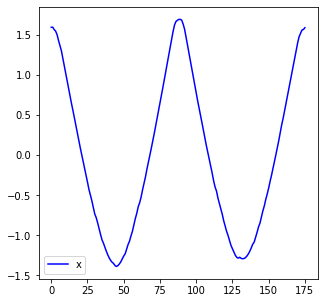

In [ ]:
TSeries(get_x(df_train.iloc[0])).show();

We can use the built_in method `ColReader`

In [ ]:
get_x=ColReader(x_cols)
get_y=ColReader('target')

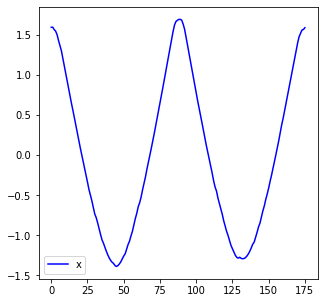

In [ ]:
TSeries(get_x(df_train.iloc[0])).show();

In [ ]:
splits = [list(range(len(df_train))), list(range(len(df_train), len(df_train)+len(df_test)))]

In [ ]:
ds = Datasets(pd.concat([df_train, df_test]).reset_index(drop=True), 
                    tfms=[[get_x, TSeries.create], [get_y, Categorize()]],
                    splits=splits, 
                   )

In [ ]:
ds.valid

(#391) [(TSeries(ch=1, len=176), TensorCategory(7)),(TSeries(ch=1, len=176), TensorCategory(29)),(TSeries(ch=1, len=176), TensorCategory(27)),(TSeries(ch=1, len=176), TensorCategory(14)),(TSeries(ch=1, len=176), TensorCategory(7)),(TSeries(ch=1, len=176), TensorCategory(24)),(TSeries(ch=1, len=176), TensorCategory(16)),(TSeries(ch=1, len=176), TensorCategory(11)),(TSeries(ch=1, len=176), TensorCategory(23)),(TSeries(ch=1, len=176), TensorCategory(5))...]

In [ ]:
dls = ds.dataloaders(bs=2)

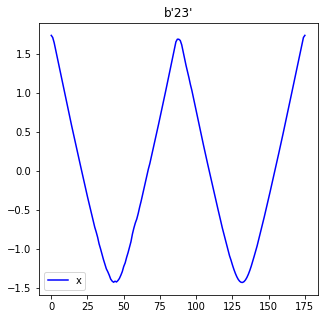

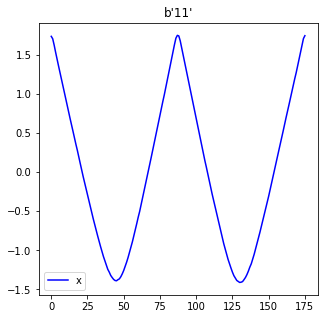

In [ ]:
dls.show_batch()

# Export -

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02_models.ipynb.
Converted 99_index.ipynb.
